In [1]:
import scvelo as scv
from IPython.display import clear_output
import matplotlib.backends.backend_pdf
from tqdm import tnrange, tqdm_notebook
import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline


scv.logging.print_version()
scv.settings.set_figure_params(
    'scvelo', dpi_save=100, dpi=80, transparent=True)
scv.settings.verbosity = 2

Running scvelo 0.1.16.dev32+c00a55e.dirty (python 3.6.6) on 2021-01-28 10:24.


In [2]:
# paths and names
data_path='G:/data/scSLAMseq/revision/'
signatures_path='G:/data/scrnaseq_signature_collection/'
figure_path='G:/data/figures/'
libraries = ['AB', 'CE', 'DF']
donors=['B2-040', 'C2-019', 'OT227', 'OT302', 'P009T', 'P013T']

In [7]:
heatmap_colors= ['HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'YAP_targets', 'HALLMARK_DNA_REPAIR', 'Stem_Lgr5_ISC-Merlos', 'MAPK_progeny', 'Stem', 'Stem_TA 1', 'Stem_TA 2', 'Stem_TA 3', 'TC1', 'TC2', 'TC3', 'TC4']  # progeny is missing
heatmap_colors_ = ['Hallmark Wnt β catenin signaling', 'YAP targets', 'Hallmark DNA repair', 'Stem Lgr5-ISC (Merlos)', 'MAPK_progeny', 'Stem', 'Stem_TA 1', 'Stem_TA 2', 'Stem_TA 3', 'TC1', 'TC2', 'TC3', 'TC4']
perturbations = ['DMSO', 'EGFR', 'EGFR + MEK', 'EGFR + BRAF', 'MEK', 'BRAF']  # in this very order
perturbations_ = ['DMSO', 'EGFRi', 'EGFRi + MEKi', 'EGFRi + BRAFi', 'MEKi', 'BRAFi']
cmap = 'bwr'

from pathlib import Path
Path(figure_path+'Fig5D_heatmap/').mkdir(parents=True, exist_ok=True)

lh = len(heatmap_colors)
lp = len(perturbations)
def compute_Z(adata):
    Z = np.zeros((lh, lp))
    for i, col in enumerate(heatmap_colors):
        for j, pert in enumerate(perturbations):
            Z[i,j] = np.mean(adata[adata.obs.perturbation==pert].obs[col])
    return Z

# Compute data for heatmap and export as excel

In [4]:
# compute Zscores
Zs=[]
for donor in tqdm_notebook(donors):
    adata=sc.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed.h5')
    Zs.append(compute_Z(adata))
    del adata

# Aggregate into tensor: donors x signatures x perturbations
tensorZ=np.array(Zs)

# shift for DMSO (normalize by DMSO)
m_DMSO = tensorZ[:,:,0]
shifted_tensorZ = tensorZ-m_DMSO[:,:,np.newaxis]

# scale to fill out color range
shifted_tensorZ/=np.max(np.abs(shifted_tensorZ), axis=(0,2))[:, np.newaxis]

# extract non_DMSO (DMSO slice would be 0 only since we normalize by DMSO)
subtensorZ_ = shifted_tensorZ[:,:,1:]  # DMSO is 0 in donor axis; filter out.

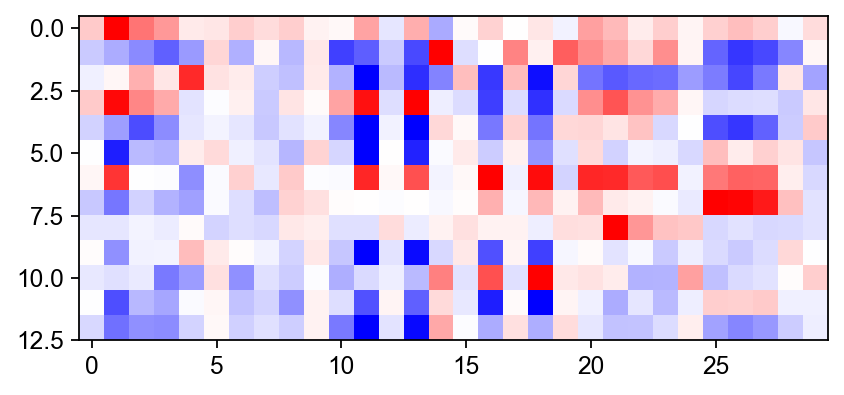

In [6]:
# test look at all donors together to check scale
v=np.max(np.abs(subtensorZ_))
pl.imshow(np.concatenate(subtensorZ_, axis=1), cmap=cmap, vmin=-1, vmax=1)

In [8]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(figure_path+'Fig5D_heatmap/heatmap_values.xlsx', engine='xlsxwriter')
for d, z in zip(donors, Zs):
    df = pd.DataFrame(z, index=heatmap_colors_, columns=perturbations_)
    # Write each dataframe to a different worksheet.
    df.to_excel(writer, sheet_name=d)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Plot and save heatmaps

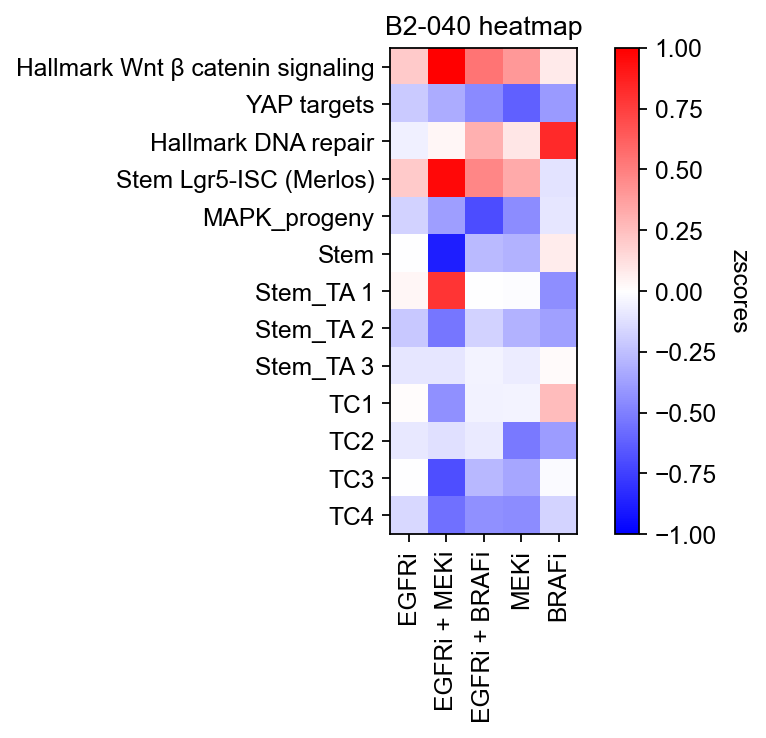

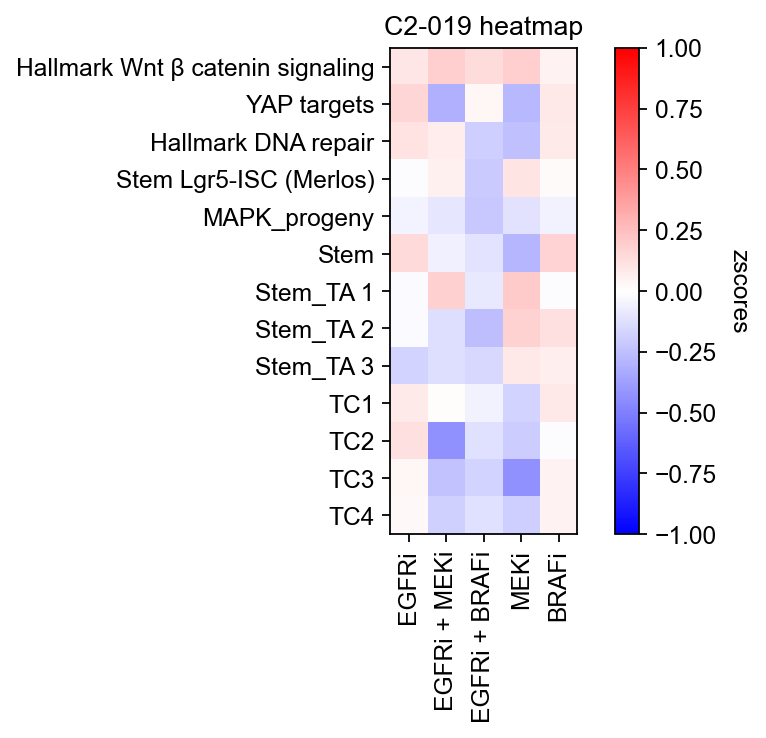

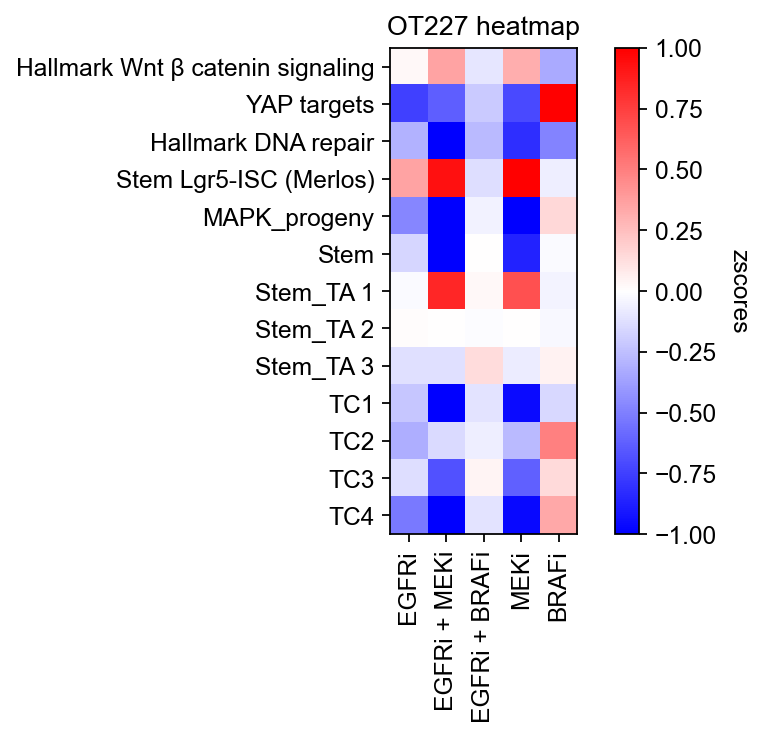

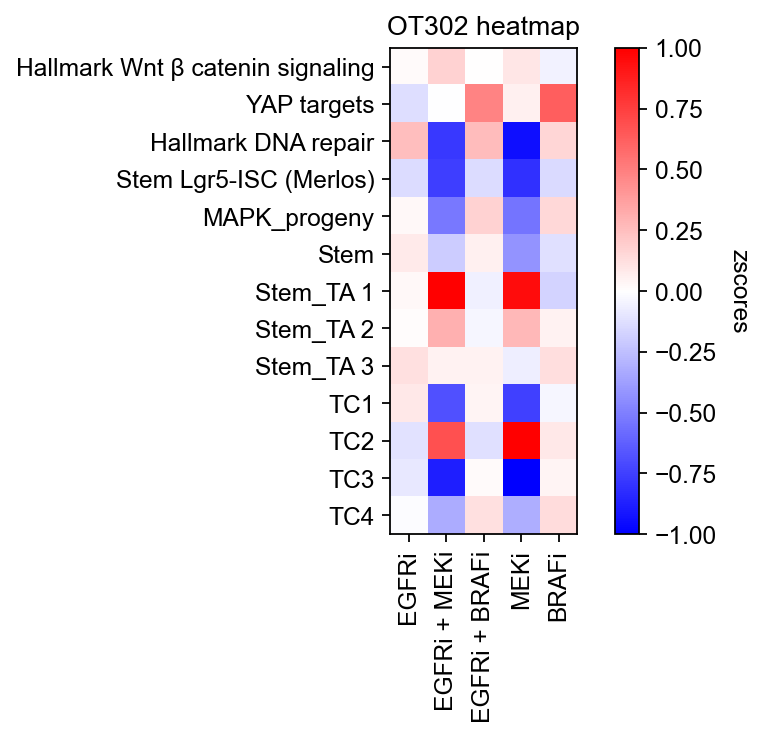

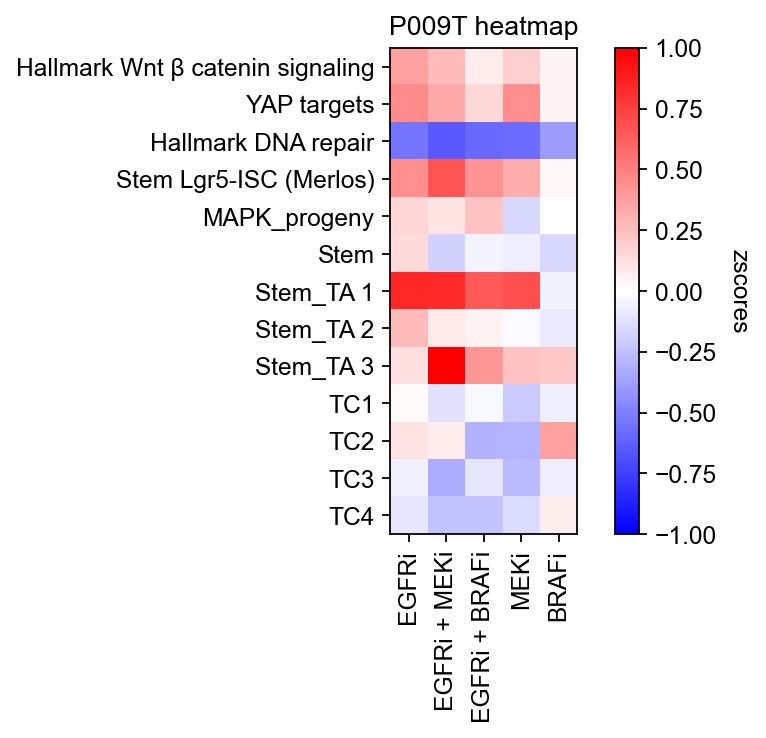

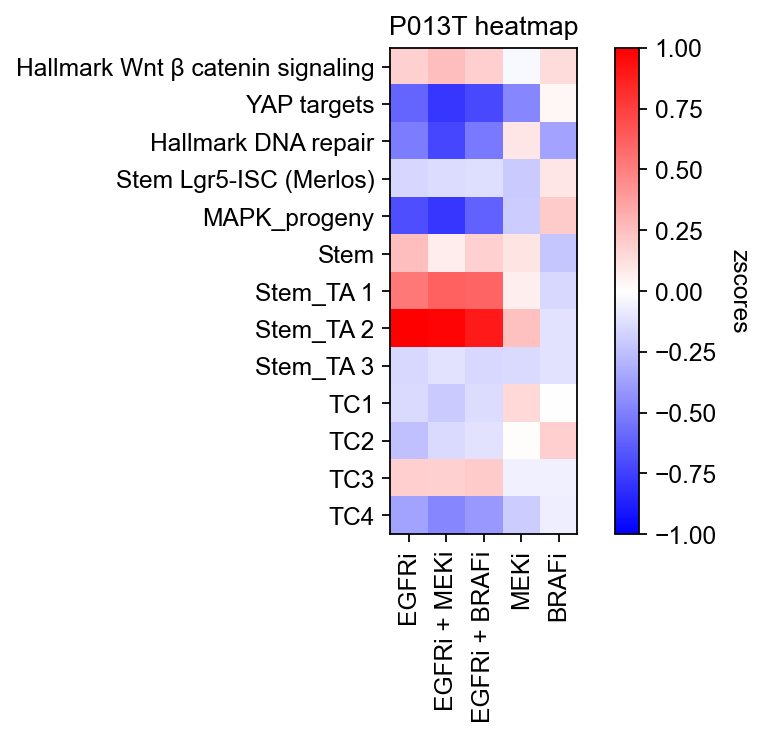

In [9]:
for i, donor in enumerate(donors):
    v=np.max(np.abs(subtensorZ_))
    im=pl.imshow(subtensorZ_[i], cmap=cmap, vmin=-v, vmax=v)
    pl.xticks(np.arange(lp), perturbations_[1:], rotation=90)
    pl.yticks(np.arange(lh), heatmap_colors_)
    pl.xlim([-0.5,4.5])
    cbar=pl.colorbar(im)
    cbar.ax.set_ylabel('zscores', rotation=270, labelpad=15)
    pl.title(donor+' heatmap')
    pl.savefig(figure_path+'Fig5D_heatmap/'+donor+'_heatmap_SLAM.pdf')
    pl.show()